## Imports Here

In [38]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchattacks
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

## Loading the CIFAR10 dataset

In [4]:
def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader


## Loading a Pretrained Model - ResNet18

In [5]:
def build_model():
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(512, 10)  # Adjust the output layer for 10 classes (CIFAR-10)
    return model.to(device)

## Training Loop

In [6]:
def train_model(model, trainloader, testloader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(trainloader)

        # Evaluate the model on the test set
        test_loss, accuracy = evaluate_model(model, testloader)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {test_loss:.4f} | "
              f"Test Accuracy: {accuracy:.2f}%")

    print('Finished Training')
    return model


def evaluate_model(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(testloader)
    return avg_test_loss, accuracy

In [ ]:
trainloader, testloader = load_data()
model = build_model()
trained_model = train_model(model, trainloader, testloader, epochs=50, lr=0.001)
torch.save(trained_model.state_dict(), "./models/resnet18_cifar10.pth")

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50] | Train Loss: 1.1058 | Test Loss: 0.8601 | Test Accuracy: 70.86%
Epoch [2/50] | Train Loss: 0.8094 | Test Loss: 0.7627 | Test Accuracy: 74.37%
Epoch [3/50] | Train Loss: 0.7275 | Test Loss: 0.7008 | Test Accuracy: 75.74%
Epoch [4/50] | Train Loss: 0.6530 | Test Loss: 0.7205 | Test Accuracy: 75.76%
Epoch [5/50] | Train Loss: 0.6052 | Test Loss: 0.6317 | Test Accuracy: 77.84%
Epoch [6/50] | Train Loss: 0.5735 | Test Loss: 0.5948 | Test Accuracy: 79.50%
Epoch [7/50] | Train Loss: 0.5469 | Test Loss: 0.6277 | Test Accuracy: 78.84%
Epoch [8/50] | Train Loss: 0.5347 | Test Loss: 0.7542 | Test Accuracy: 76.30%
Epoch [9/50] | Train Loss: 0.5012 | Test Loss: 0.5614 | Test Accuracy: 80.99%
Epoch [10/50] | Train Loss: 0.4794 | Test Loss: 0.5617 | Test Accuracy: 80.68%
Epoch [11/50] | Train Loss: 0.4644 | Test Loss: 0.5142 | Test Accuracy: 82.56%
Epoch [12/50] | Train Loss: 0.4365 | Test Loss: 0.5143 | Test Ac

## Attacking the "Normally" Trained Model

In [42]:
# Function to un-normalize the images to display them properly
def unnormalize(img, mean, std):
    img = img.clone()  # Clone the tensor to avoid modification
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Unnormalize each channel
    return img

# Load the trained model
def load_model():
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = torch.nn.Linear(512, 10)
    model.load_state_dict(torch.load("./models/resnet18_cifar10.pth"))
    return model.to(device)

# Display clean and adversarial examples side by side
def display_images(clean_img, adv_img, label, pred_clean, pred_adv):
    clean_img = clean_img.cpu().detach()
    adv_img = adv_img.cpu().detach()

    # Unnormalize the images for visualization
    clean_img = unnormalize(clean_img, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    adv_img = unnormalize(adv_img, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

    clean_img = np.transpose(clean_img.numpy(), (1, 2, 0))
    adv_img = np.transpose(adv_img.numpy(), (1, 2, 0))

    # Plot clean and adversarial images
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    axs[0].imshow(clean_img)
    axs[0].set_title(f'Clean: Label {label}, Pred {pred_clean}')
    axs[0].axis('off')
    
    axs[1].imshow(adv_img)
    axs[1].set_title(f'Adversarial: Pred {pred_adv}')
    axs[1].axis('off')

    plt.show()

# Apply FGSM attack and display images
def apply_fgsm_attack(model, testloader, epsilon=0.03):
    model.eval()  # Set model to evaluation mode
    atk = torchattacks.FGSM(model, eps=epsilon)  # FGSM attack instance

    correct_clean = 0
    correct_adv = 0
    total = 0

    # We'll just display a few images for illustration
    images_to_display = 5
    display_count = 0

    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial examples
        adv_inputs = atk(inputs, labels)

        # Test clean examples
        outputs_clean = model(inputs)
        _, predicted_clean = outputs_clean.max(1)

        # Test adversarial examples
        outputs_adv = model(adv_inputs)
        _, predicted_adv = outputs_adv.max(1)

        total += labels.size(0)
        correct_clean += (predicted_clean == labels).sum().item()
        correct_adv += (predicted_adv == labels).sum().item()

        # Display a few examples
        if display_count < images_to_display:
            for i in range(min(images_to_display - display_count, inputs.size(0))):
                display_images(inputs[i], adv_inputs[i], labels[i].item(), 
                               predicted_clean[i].item(), predicted_adv[i].item())
                display_count += 1

    print(f'Accuracy on clean examples: {100 * correct_clean / total:.2f}%')
    print(f'Accuracy after FGSM attack: {100 * correct_adv / total:.2f}%')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


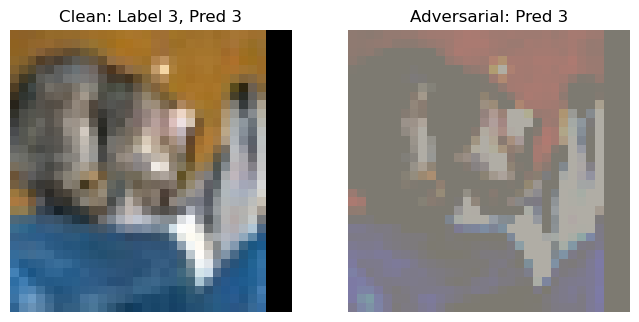

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


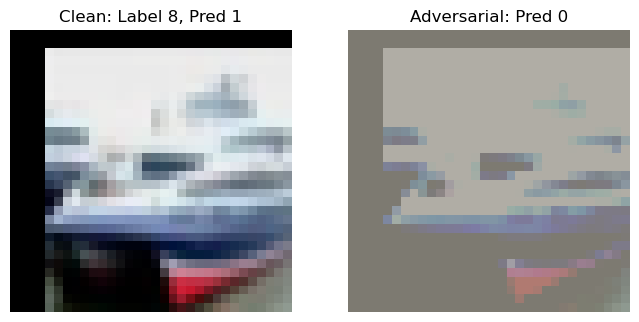

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


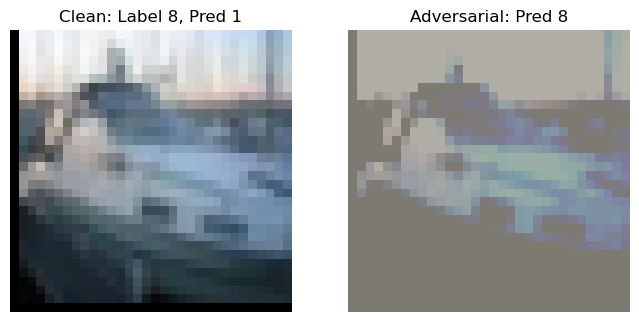

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


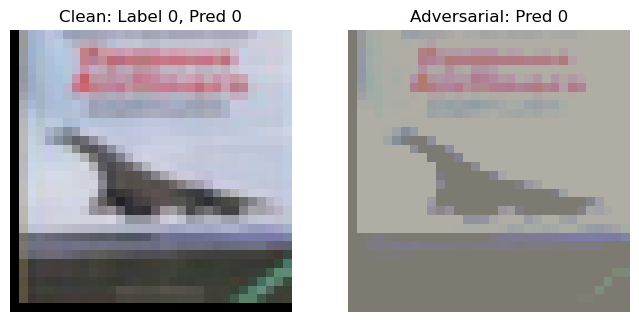

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


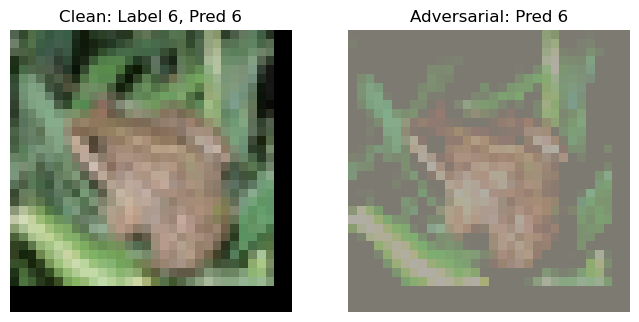

Accuracy on clean examples: 85.00%
Accuracy after FGSM attack: 43.60%


In [46]:
_, testloader = load_data(batch_size=64)
model = load_model()
apply_fgsm_attack(model, testloader, epsilon=0.001)

## Adversarial Training

In [ ]:
def adversarial_training(epochs=10, lr=0.001, epsilon=0.03):
    trainloader, testloader = load_data(batch_size=64)  # Load both training and test data
    model = build_model()

    atk = torchattacks.FGSM(model, eps=epsilon)  # FGSM attack instance with epsilon value

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Generate adversarial examples
            adv_inputs = atk(inputs, labels)

            # Mix clean and adversarial inputs
            mixed_inputs = torch.cat([inputs, adv_inputs], 0)
            mixed_labels = torch.cat([labels, labels], 0)

            optimizer.zero_grad()
            outputs = model(mixed_inputs)
            loss = criterion(outputs, mixed_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(trainloader)

        # Evaluate the model on the test set after each epoch
        test_loss, accuracy = evaluate_model(model, testloader)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {test_loss:.4f} | "
              f"Test Accuracy: {accuracy:.2f}%")

    print('Finished Adversarial Training')
    torch.save(model.state_dict(), "./models/adversarially_trained_model.pth")

In [ ]:
adversarial_training(epochs=50, lr=0.001, epsilon=0.03)